# Generative Adversarial Networks

In [2]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np

from torchvision.datasets import mnist, cifar
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from random import sample
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from IPython import display



First lets get some data ready

In [3]:
class DataLoad():
    
    def __init__(self):
        pass
    
    def load_data_mnist(self, batch_size=128):
        
        mnist_data = mnist.MNIST(root = './data/mnist',
                                train = True,
                                download = True,
                                transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        # Comment this line out if you wish to use the full dataset.
        mnist_data = torch.utils.data.Subset(mnist_data, sample(list(range(0,30000)), batch_size*100)) 
        
        mnist_loader = DataLoader(mnist_data, 
                                  batch_size = batch_size, 
                                  shuffle=True)
        
        return mnist_loader
    
    def load_data_cifar10(self, batch_size=128):
        
        cifar_data = cifar.CIFAR10(root = './data/cifar10',
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        # Comment these two lines out if you wish to use the full dataset.
        sample_range = sample(list(range(0,25000)), batch_size*120)
        cifar_data = torch.utils.data.Subset(cifar_data, sample_range)
        
        cifar_loader = DataLoader(cifar_data,
                                  batch_size = batch_size,
                                  shuffle = True)
        
        return cifar_loader        

In [4]:
def load_data(ds):
    
    # Initialize the dataloader
    data_loader = DataLoad()
    
    # Load training data into the dataloader
    if ds == 'mnist':
        train_loader = data_loader.load_data_mnist(batch_size = batch_size)
    elif ds == 'cifar10':
        train_loader = data_loader.load_data_cifar10(batch_size = batch_size)
    
    return train_loader



As we discussed in class, GANs are composed of two models, represented by neural networks:
* The first model is called a **Generator** and it aims to generate new data similar to the expected one. 
* The second model is named the **Discriminator** and it aims to recognize if an input data is ‘real’ — belongs to the original dataset — or if it is ‘fake’ — generated by a forger.


* **Generator Network**: The input to the generator is a series of randomly generated numbers called **latent sample**. It tries to produce data that come from some probability distribution. The generator network takes random noise as input, then runs that noise through a differentiable function to transform the noise and reshape it to have recognizable structure. The output of the generator network ia a realistic image. Without training, the generator produces garbage images only. 
    
    So z (latent sample, vector of unstructured noise) is essentially a vector of unstructured noise. It’s a source of randomness that allows the generator to output a wide variety of different vectors.


* **Discriminator Network**: The discriminator is a **classifier** trained using the **supervised learning**. It classifies whether an image is real (1) or is fake (0).


* **Training GANs: Two player game**: The Generator (forger) needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore. The competition between these two teams is what improves their knowledge, until the Generator succeeds in creating realistic data.

    $G$ try to fool discriminator by generating real-looking images.

    $D$ try to distinguish between real and fake images.

    Train jointly in **minimax game**
    
### Network Design

<p align="center">
    <img src="network_design_gan.png" width="600"\>
</p>


Below is our Generator model. Now that we've had some experience with building our own architectures, get creative and build your own hidden layers.

In [71]:
class Generator(nn.Module):
    
    def __init__(self, model_type, noise_dim=100):
        
        super(Generator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            
            'mnist': nn.Sequential(
                            # TODO: fill in `None` values and build your 
                            #       hidden layers.
                            nn.Linear(noise_dim, 100, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(100, 250),
                            nn.LeakyReLU(0.4, inplace=True),
                            nn.Linear(250, 500),
                            nn.LeakyReLU(0.3, inplace=True),
                            nn.Linear(500, 750),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(750, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh()                
                            ),
            
            'cifar10': nn.Sequential(
                            # TODO: fill in `None` values and build your 
                            #       hidden layers.
                            nn.Linear(noise_dim, 100, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(100, 250),
                            nn.LeakyReLU(0.4, inplace=True),
                            nn.Linear(250, 500),
                            nn.LeakyReLU(0.4, inplace=True),
                            nn.Linear(500, 750),
                            nn.LeakyReLU(0.3, inplace=True),
                            nn.Linear(750, 1000),
                            nn.LeakyReLU(0.3, inplace=True),
                            nn.Linear(1000, 1500),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1500, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh()                
                            ),
                })
        
    def forward(self, z):
        img = self.models[self.model_type](z)
        img = img.view(img.size(0), *self.image_shape[self.model_type])            
        return img

Also build your hidden layers for the Discriminator. Dont forget to fill any `None` values you see.

In [72]:

class Discriminator(nn.Module):
    
    def __init__(self, model_type):
        
        super(Discriminator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            'mnist': nn.Sequential(
                            # TODO: Build your hidden layers. Remember to fill any 
                            #       `None` values you see.
                            nn.Linear(int(np.prod(self.image_shape[model_type])),500),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(500,250),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(250,1),
                            nn.Sigmoid(),
                ),
            
            'cifar10': nn.Sequential(
                            # TODO: Build your hidden layers. Remember to fill any 
                            #       `None` values you see.
                            nn.Linear(int(np.prod(self.image_shape[model_type])),1000),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1000,500), 
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(500,250),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(250,100),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(100,1),
                            nn.Sigmoid(),
                ),
            })
        
    def forward(self, img):        
        img_flat = img.view(img.size(0),-1)
        output = self.models[self.model_type](img_flat)        
        return output

In [73]:
# Use GPU if available
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if cuda else 'cpu'
device

'cpu'

Below are the initial hyperparameters for training. Expect to return to this cell for tuning.

In [74]:
batch_size = 64
beta1 = 0.5
beta2 = 0.999

total_epochs = 100
learning_rate = 1e-4
noise_dim = 100
k = 3

In [75]:
# Generate some fixed noise to use down the road.
fixed_noise = torch.randn(16, noise_dim, device=device)

# Set real/fake designations:

real = float(1)
fake = float(0)

### Cost function

Minimax objective function (Value Function or Cost Function of Minimax Game played by Generator and Discriminator):

$$ \underset{\theta_{g}}{min} \: \underset{\theta_{d}}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D_{\theta_{d}}(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))]$$

* $D_{\theta_{d}}$ wants to maximize  objective such that $D(x)$ is close to 1 (real) and $D(G(z))$ is close to 0 (fake).
* $G_{\theta_{g}}$ wants to minimize objective such that $D(G(z))$ is close to 1 (discriminator is fooled into thinking generated G(z) is real).

Alternate between:
1. Gradient ascent on D
$$\underset{\theta_{d}}{max} [\mathbb{E}_{x\sim p_{data}(x)}log D_{\theta_{d}}(x) + \mathbb{E}_{z\sim p_{z}(z)}log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))]$$

2. Instead: Gradient ascent on generator, different objective
$$\underset{\theta_{g}}{max}[\mathbb{E}_{z\sim p_{z}(z)}[log( D_{\theta_{d}}(G_{\theta_{g}}(z)))] $$

Instead of minimizing likelihood of discriminator being correct, now maximize likelihood of discriminator being wrong. Same objetive of fooling discriminator, but now higher gradient signal for bad samples => works much better!

As a result, 
* the Discriminator is trained to correctly classify the input data as either real or fake. 
    * This means it’s weights are updated as to maximize the probability that any real data input x is classified as belonging to the real dataset, while minimizing the probability that any fake image is classified as belonging to the real dataset. 
    * In more technical terms, the loss/error function used maximizes the function D(x), and it also minimizes D(G(z)).
* the Generator is trained to fool the Discriminator by generating data as realistic as possible, which means that the Generator’s weight’s are optimized to maximize the probability that any fake image is classified as belonging to the real dataset. Formally this means that the loss/error function used for this network maximizes D(G(z)).

In [76]:
# Load training data:
dataset = 'cifar10' # 'mnist' or 'cifar10'
train_loader = load_data(dataset)

Files already downloaded and verified


In [77]:
# Loss function
criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator(dataset)
discriminator = Discriminator(dataset)

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()

# Optimizers
optimizer_generator = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (beta1, beta2))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (beta1, beta2))

Below is the training procedure, but with `None` values sprinked throughout. 

*TODO*:
* Replace `None` values with necessary objects.
* Collect losses in lists for further analysis.

On execution, the image grid will update after each epoch. Watch your images update and make note of how they evolve throughout training.

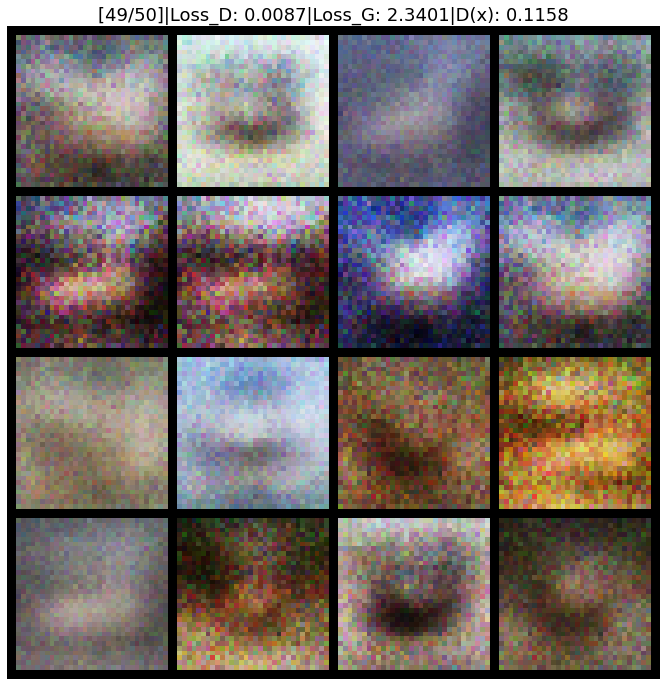

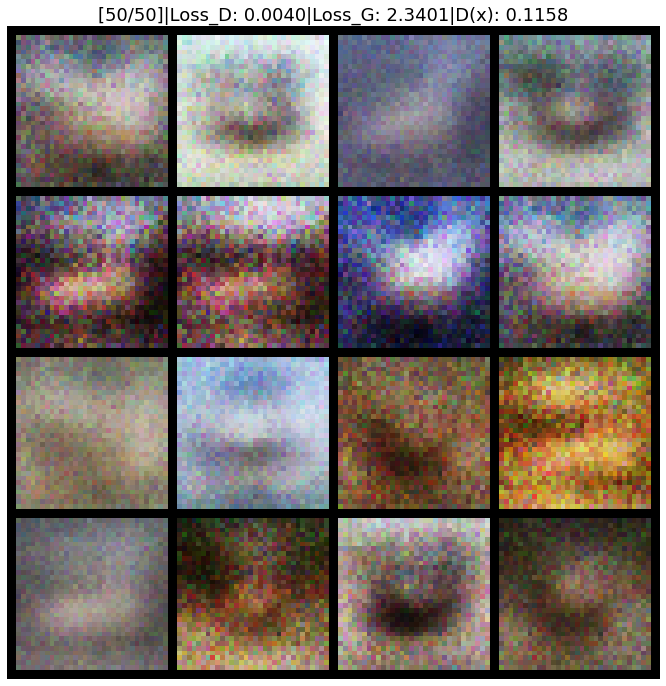

In [103]:

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')

total_epochs = 50

loss_generator = []
loss_discriminator = []
error_generator = []
error_discriminator = []

loss = nn.MSELoss()

# Training Loop

for epoch in range(total_epochs):
    # update the discriminator k times before updating the generator
    for i, (imgs, _) in enumerate(train_loader):
        
        imgs = imgs.to(device)
        
        # TODO: Set up some 'truth' variables here so that way the discriminator has something to check against.
        # real and fake
        valid = Variable(torch.Tensor(imgs.size(0),1).fill_(real), requires_grad=False).to(device)
        false = Variable(torch.Tensor(imgs.size(0),1).fill_(fake), requires_grad=False).to(device)
        
        optimizer_discriminator.zero_grad()
        
        # Calculate the loss on the all-real batch
        # TODO: What do we want to be comparing our discriminator against?
        # 
        d_imgs = discriminator(imgs)
        real_loss = criterion(d_imgs, valid)
        real_error = loss(d_imgs, valid)

        # Generate some random noise
        # TODO: What kind of distribution do we want to be using for this? (replace the None in the next line with the answer)
        # The normal distribution
        noise = Variable(torch.Tensor(np.random.normal(0,1, (imgs.shape[0], noise_dim)))).to(device)
        
        # TODO: We want some fake images here from the noise, how would we create them?
        # Call the forward function of the generator and pass in the noise we just sampled
        gen_imgs = generator(noise)
        
        # Now we examine how well our discriminator does against the false data, so thus
        d_imgs = discriminator(gen_imgs.detach())
        fake_loss = criterion(d_imgs, false)
        fake_error = loss(d_imgs, false)

        # TODO: Now we need to have the loss for our discriminator. How would we do this?
        
        loss_D = real_loss + fake_loss
        error_D = real_error + fake_error

        loss_discriminator.append(loss_D.item())
        error_discriminator.append(error_D.item())

        # Calculate the gradients        
        loss_D.backward()
        
        # Update D
        optimizer_discriminator.step()
        
        
        # Update generator network: maximize log(D(G(z)))
        # This only fires after k steps of discriminator optimization
        
        if (epoch+1)%k == 0:
            optimizer_generator.zero_grad()

            # TODO: We need to now update our generator. What would the first step here?
            # 
            gen_imgs = generator(noise)
            output = discriminator(gen_imgs)

            # Now we need to calculate the probability of the discriminator classifying the fake images as real
            # If this probability is close to 0, then the generator has learnt how to fool the discriminator

            D_x = output.mean().item()

            # TODO: What information would we want to have in order to properly update our generator?
            # valid
            loss_G = criterion(output, valid)
            error_G = loss(output, valid)

            loss_generator.append(loss_G.item())
            error_generator.append(error_G.item())

            # Calculate gradients for the generator:
            loss_G.backward()

            # Update  the generator
            optimizer_generator.step()

            
    display.clear_output(wait=True)
    display.display(plt.gcf())

    fake_sample = generator(fixed_noise)
    image_grid = make_grid(fake_sample.to(device),
                           padding=2,
                           nrow=4,
                           normalize = True)
    ax.imshow(image_grid.cpu().permute(1,2,0))
    if epoch>k:
        ax.set_title('[%d/%d]|Loss_D: %.4f|Loss_G: %.4f|D(x): %.4f'
                    % (epoch+1, total_epochs, 
                        loss_D.item(),
                        loss_G.item(),
                        D_x),
                    size=18)

**What did you notice about your images as they updated? How would you describe the final result?**

They didn't really resemble anything in particular. They looked kind of ghostly like when drawing from a PCA - there is form, there is tonal variation to indicate shading of some kind, and there is color. So the generator network is learning about images, it just hasn't learned to create any one image in particular. It's an amalgamation of many images which gives interesting results.
<p align='center'>
    <img src=result_0a.png>
</p>

When I increased the number of epochs, the generator ended up learning too much. It looks like you've put the image through a contrast enhancer many times... Now the images are not realistic at all and they resemble nothing.
<p align='center'>
    <img src=result_0.png>
</p>

*TODO*:
* Plot your generator and discriminator errors.
* Explain how these errors support your qualitative assessment of the images rendered.
* Return to your model arch. How might changing your architecture improve your result? Make those adjustments to your Discriminator and/or Generator models.
* Return to the model hyperparameters. You may notice one or more may be sub-optimal. Adjust values and rerun the training loop. How do these adjustments improve/degrade your previous result? Why?

I changed the batch size to be 128, epochs to 100 and noise dimension to be 300. What happened was the images went through a stage where they appeared to be representing something, but then the generator network was overlearning and the images no longer resembled anything by the end. The performance definitely improved up to a point and then degraded after that.

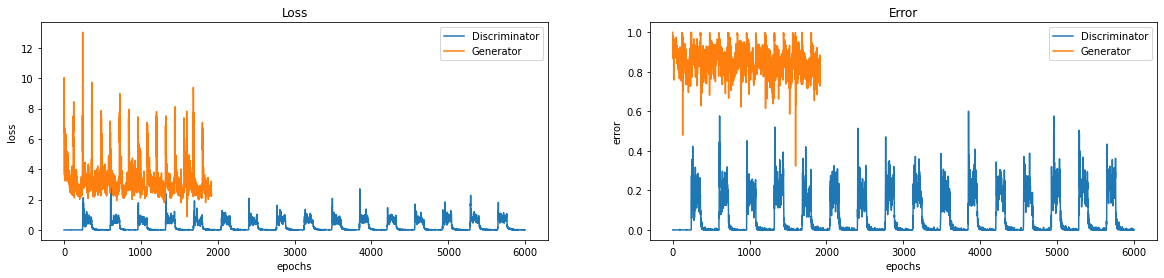

In [109]:
fix,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
ax1.set_title('Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(loss_discriminator,label='Discriminator')
ax1.plot(loss_generator,label='Generator')
ax1.legend()

ax2.set_title('Error')
ax2.set_xlabel('epochs')
ax2.set_ylabel('error')
ax2.plot(error_discriminator,label='Discriminator')
ax2.plot(error_generator,label='Generator')
ax2.legend()

Error remains fairly high for the duration of the training process. The reason is that the generator network never actually sees the real data that is represented by the distribution the generator is trying to model, and so as I mentioned earlier when I said the pictures resemble PCA components in that they are ghostly and don't resemble anything in particular, we see that the error will remain high because the discriminator will be able to detect really well which image is generated and which is not. With more epochs and better network design, we would likely see a drop in the error of the generator network. 

## BONUS

CIFAR is an interesting dataset and can yield interesting images for generative networks-- but can require more involved model tuning to get realistic output. 

You'll notice the code in this notebook has been built to additionally support the MNIST dataset. Copy the necessary cells to below, and rerun the training with `dataset = 'mnist'`. Now watch your images update. Does this datatset yield a faster time-to-realism? What does this day about the dataset and latent space?

Experimenting as above with some of the model parameters:
The number of hidden layers for the networks are the same and there is only one layer:
* The pictures started off as just noise, but over time they began to resemble digits. Many of them looked like something real, but they weren't distinguishable as real digits.

The number of hidden layers in the generator is double the number layers in the discriminator:
* The pictures looked a lot more like digits, and a lot faster too, which means the generator is strong-arming that discriminator and learning much faster.

When I increased the number of layers in the networks, the result was that the images resembled digits a lot faster than in the previous example. Because the contrast was much higher now, the values did not look like any one particular digit.
I then removed a layer from the discriminator network, and reduced the number of nodes in the layers, thus weakning its ability to learn. The result was that the generator started to produce images that looked more like digits, but they were still not very realistic:
<p align=center>
    <img src="result_1.png">
</p>

The images certainly did achieve a semblance of realism a lot faster than the cifar dataset. It seems that it is much more difficult to learn about the generating distribution when the images are more complex.

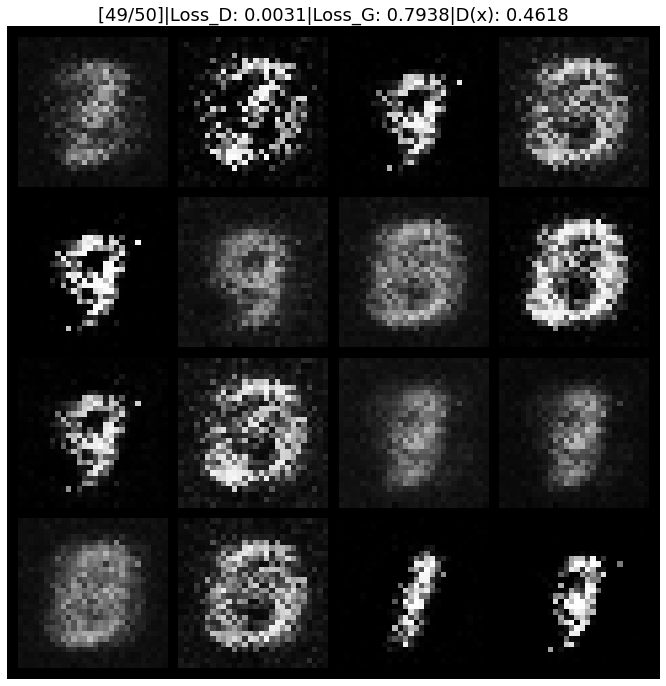

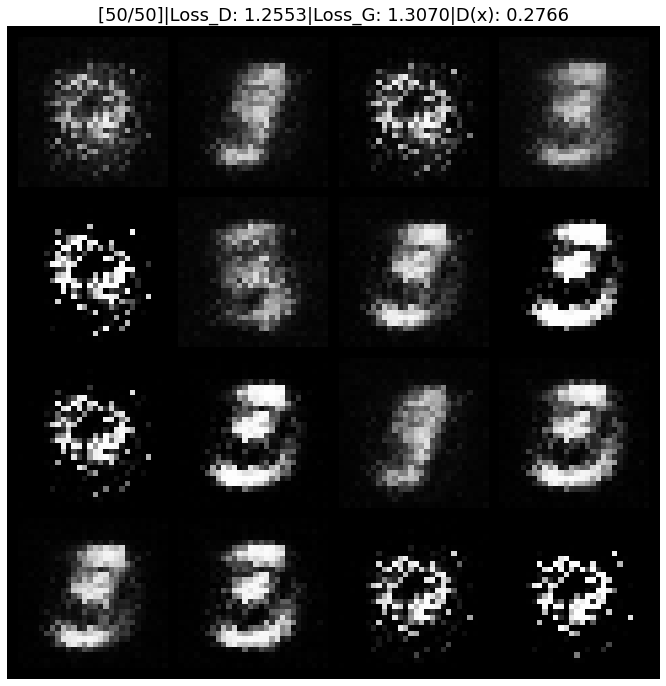

In [45]:
total_epochs = 50

# Load training data:
dataset = 'mnist' # 'mnist' or 'cifar10'
train_loader = load_data(dataset)

# Loss function
criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator(dataset)
discriminator = Discriminator(dataset)

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()

# Optimizers
optimizer_generator = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (beta1, beta2))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (beta1, beta2))


fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')


loss_generator = []
loss_discriminator = []

# Training Loop

for epoch in range(total_epochs):
    # update the discriminator k times before updating the generator
    for i, (imgs, _) in enumerate(train_loader):
        
        imgs = imgs.to(device)
        
        # TODO: Set up some 'truth' variables here so that way the discriminator has something to check against.
        # real and fake
        valid = Variable(torch.Tensor(imgs.size(0),1).fill_(real), requires_grad=False).to(device)
        false = Variable(torch.Tensor(imgs.size(0),1).fill_(fake), requires_grad=False).to(device)
        
        optimizer_discriminator.zero_grad()
        
        # Calculate the loss on the all-real batch
        # TODO: What do we want to be comparing our discriminator against?
        # 
        real_loss = criterion(discriminator(imgs), valid)
        
        # Generate some random noise
        # TODO: What kind of distribution do we want to be using for this? (replace the None in the next line with the answer)
        # The normal distribution
        noise = Variable(torch.Tensor(np.random.normal(0,1, (imgs.shape[0], noise_dim)))).to(device)
        
        # TODO: We want some fake images here from the noise, how would we create them?
        # Call the forward function of the generator and pass in the noise we just sampled
        gen_imgs = generator(noise)
        
        # Now we examine how well our discriminator does against the false data, so thus
        fake_loss = criterion(discriminator(gen_imgs.detach()), false)
        
        # TODO: Now we need to have the loss for our discriminator. How would we do this?
        
        loss_D = real_loss + fake_loss
        
        loss_discriminator.append(loss_D)

        # Calculate the gradients        
        loss_D.backward()
        
        # Update D
        optimizer_discriminator.step()
        
        
        # Update generator network: maximize log(D(G(z)))
        # This only fires after k steps of discriminator optimization
        
        if (epoch+1)%k == 0:
            optimizer_generator.zero_grad()

            # TODO: We need to now update our generator. What would the first step here?
            # 
            gen_imgs = generator(noise)
            output = discriminator(gen_imgs)

            # Now we need to calculate the probability of the discriminator classifying the fake images as real
            # If this probability is close to 0, then the generator has learnt how to fool the discriminator

            D_x = output.mean().item()

            # TODO: What information would we want to have in order to properly update our generator?
            # valid
            loss_G = criterion(output, valid)

            loss_generator.append(loss_G)
            
            # Calculate gradients for the generator:
            loss_G.backward()

            # Update  the generator
            optimizer_generator.step()

            
    display.clear_output(wait=True)
    display.display(plt.gcf())

    fake_sample = generator(fixed_noise)
    image_grid = make_grid(fake_sample.to(device),
                           padding=2,
                           nrow=4,
                           normalize = True)
    ax.imshow(image_grid.cpu().permute(1,2,0))
    if epoch>k:
        ax.set_title('[%d/%d]|Loss_D: %.4f|Loss_G: %.4f|D(x): %.4f'
                    % (epoch+1, total_epochs, 
                        loss_D.item(),
                        loss_G.item(),
                        D_x),
                    size=18)